In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import seaborn as sns
import pandas as pd
from pathlib import Path
from utils import *
from ucr import *
from models import *
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import fastai
from fastai.vision import *

In [ ]:
task = 'Adiac'

In [ ]:
# DATAPATH = Path.cwd()/'Univariate_arff' #if not Adiac
DATAPATH = Path.cwd()

In [ ]:
sorted(list(DATAPATH.iterdir()))

[PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.git'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.gitignore'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.ipynb_checkpoints'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.vscode'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/01_adiac-LBFGS.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/01_adiac-inception.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/01_adiac.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/02_adiac_inception_resnet.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Adiac'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/README.md'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/__pycache__'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/dev_merge.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fa

In [ ]:
df_train, df_test = load_df(DATAPATH, task)

Loading files from: /home/tc256760/Documents/TimeSeries_fastai/Adiac


In [ ]:
num_classes = df_train.target.nunique(); num_classes

37

# DL

In [ ]:
x_train, y_train, x_test, y_test = process_dfs(df_train, df_test)

In [ ]:
x_train.shape, x_test.shape

((390, 176), (391, 176))

In [ ]:
x_train[0].shape

(176,)

In [ ]:
tr_ds, val_ds = to_TDS(x_train, y_train), to_TDS(x_test, y_test)

In [ ]:
bs = max_bs(len(tr_ds)); bs

32

In [ ]:
db = create_databunch(tr_ds, val_ds, bs)

Testing dims at input/output

## Resnet 1D

In [ ]:
tx, ty = next(iter(db.train_dl))
print(tx.shape, ty.shape)

torch.Size([32, 1, 176]) torch.Size([32])


In [ ]:
model = create_resnet(1, num_classes, conv_sizes=[64, 128, 256], stride=1)

In [ ]:
# model = create_mlp(x_train[0].shape[0], num_classes)

In [ ]:
# model = create_fcn(1, num_classes)

In [ ]:
model

Sequential(
  (0): Sequential(
    (0): Conv1d(1, 64, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): MergeLayer()
    )
  )
  (2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (3): Sequent

Sanity check

In [ ]:
model.cuda()(tx).shape  #should be (bs, num_classes)

torch.Size([32, 37])

In [ ]:
learn_res = fastai.basic_train.Learner(db, 
                                       model, 
                                       loss_func = CrossEntropyFlat(), 
                                       metrics=[error_rate],
                                       wd=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


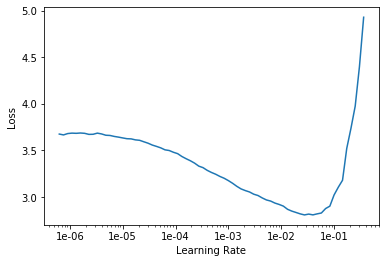

In [ ]:
learn_res.lr_find(); learn_res.recorder.plot()

In [ ]:
learn_res.fit_one_cycle(40, 5e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.910419,4.189099,0.964194,00:00
1,2.582878,4.567795,0.979540,00:00
2,2.378754,3.986807,0.920716,00:00
3,2.231789,4.411092,0.907928,00:00
4,2.095835,13.189095,0.946292,00:00
5,1.981513,14.027284,0.902813,00:00
6,1.896778,11.934660,0.959079,00:00
7,1.790373,16.972364,0.923274,00:00
8,1.707369,21.394207,0.849105,00:00
9,1.644371,17.333090,0.930946,00:00


In [ ]:
err = torch.stack([t[0] for t in learn_res.recorder.metrics]).min()  

In [ ]:
err

tensor(0.1969)

In [ ]:
p, t = learn_res.get_preds()

In [ ]:
error_rate(p,t)

tensor(0.2020)

In [ ]:
def get_cm(p, t): return confusion_matrix(t, p.softmax(dim=1).argmax(1))

Confusion Matrix

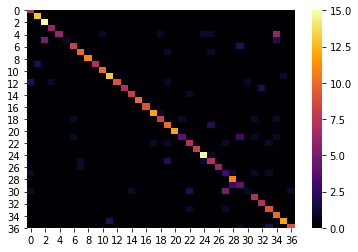

In [ ]:
sns.heatmap(get_cm(p,t), cmap='inferno')